## Image Captioning
*Text Generation from Image Data (using CNN and LSTM)*

* **Workflow**
    * We feed our images to a **pre-trained CNN (VGG16 in our case)** and **store their features corresponding the labels in a dict(map)**.
    * We **clean** the caption texts, and **store them with their corresponding labels in a dict(map).**
    * We do a **train test split** of 9:1 train-test-ratio in our image labels (keys).
    * We create a **Data Generator** to feed data to our main model in batches (to avoid memory overload).
        * Data Generator will tokenize and pad sequences in itelf and return a data generator object.
        * Data Generator Object yields: Image features, Input sequence (padded) and Output word (encoded).
    * We then **create a model** with takes two inputs:
        * Image features (outputs generated by VGG16 model)
        * Text features (Input Sequence)**(And training labels will be Output Word)**
    * We **Visualize and Train the model** by feeding Data Generator Object with adjustable epochs and batch_size.
    * We **evaluate** the test images using **BLEU score** metric.
    * We check results on dataset images.
    * Finally we feed random images and check their results.

In [1]:
# essential libraries
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('/kaggle/input/flickr8k/')
os.listdir()

['captions.txt', 'Images']

In [2]:
# tensorflow libraries/dependencies:
import tensorflow as tf
from tensorflow import keras
print(f"Tensorflow Version: {tf.__version__}")
print(f"Number of GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

# necessary preprocessing libraries:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from tensorflow.keras.utils import plot_model

# layers:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten, add

Tensorflow Version: 2.12.0
Number of GPUs Available: 2


In [3]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 16.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
# defining directories:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

## Visualization

In [5]:
# import dataset of labels
temp_df = pd.read_csv(os.path.join(BASE_DIR,'captions.txt'))
temp_df = temp_df.groupby('image').first().reset_index()
temp_df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
2,1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front o...
3,1003163366_44323f5815.jpg,A man lays on a bench while his dog sits by him .
4,1007129816_e794419615.jpg,A man in an orange hat starring at something .
...,...,...
8086,990890291_afc72be141.jpg,A man does a wheelie on his bicycle on the sid...
8087,99171998_7cc800ceef.jpg,A group is sitting around a snowy crevasse .
8088,99679241_adc853a5c0.jpg,A grey bird stands majestically on a beach whi...
8089,997338199_7343367d7f.jpg,A person stands near golden walls .


In [6]:
# function for image and label visualization

def display_images(temp_df):
    def readImage(path,img_size=224):
        img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
        img = img_to_array(img)
        img = img/255.
        return img
    from textwrap import wrap
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(5,5,n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(os.path.join(BASE_DIR,'Images',temp_df['image'].iloc[i]))
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df['caption'].iloc[i], 20)))
        plt.axis("off")

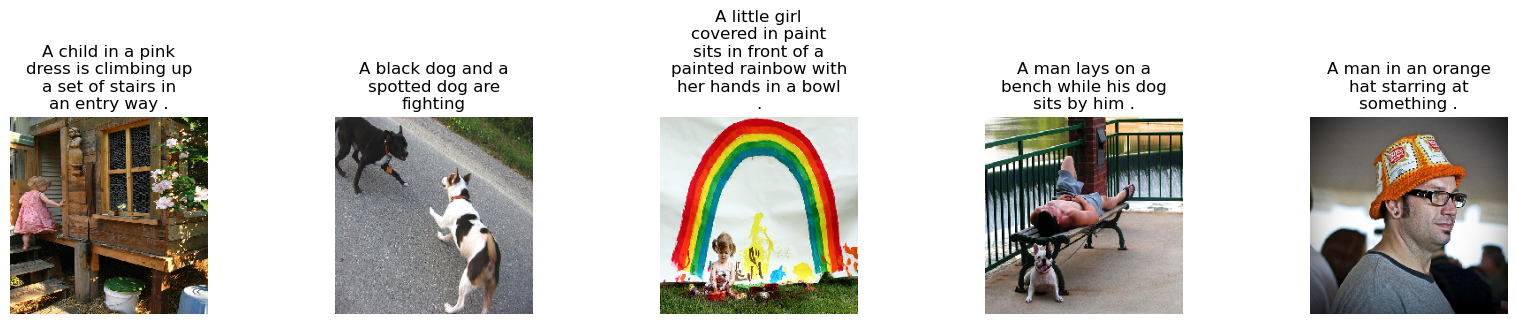

In [7]:
display_images(temp_df)

## Load, Extract and Store Image Features

### Import VGG16 model

In [8]:
%%time
# load the predefined VGG16 model:
img_model = VGG16()
# restructure the model (exclude the last dense layer):
img_model = Model(inputs = img_model.inputs, outputs = img_model.layers[-2].output)

display(img_model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

None

CPU times: user 4.67 s, sys: 2.87 s, total: 7.54 s
Wall time: 10.6 s


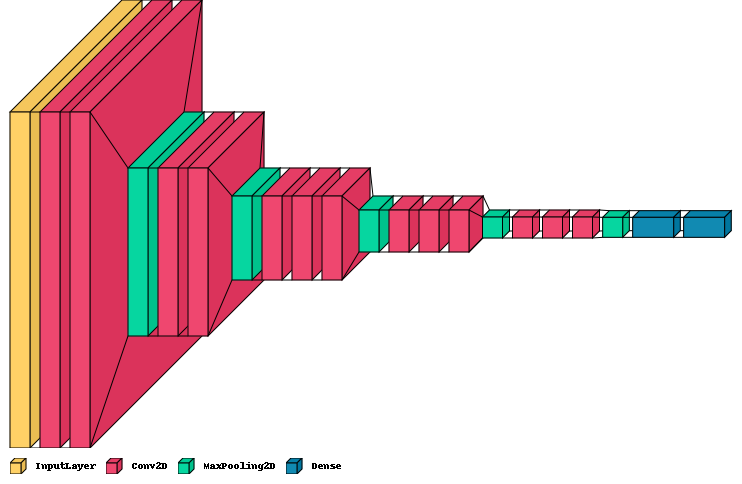

In [9]:
# visualize VGG16 (img_model):
import visualkeras
visualkeras.layered_view(img_model, draw_volume=True, scale_xy=1.5,scale_z=0.01, legend=True, type_ignore=[Flatten,Dropout])

### Feature Extraction

In [10]:
# function for feature extraction from images:
def feature_extraction(model,path):
    features = {}
    img_size = 224
    
    for img_name in tqdm(os.listdir(path)):
        img_path = os.path.join(path,img_name)
        # load image from file
        img = load_img(img_path, target_size=(img_size,img_size))
        # convert image to numpy array
        img = img_to_array(img)
        # reshape and preprocess image data for model
        img = np.expand_dims(img,axis=0)
        img = preprocess_input(img)
        # extract features
        feature = model.predict(img, verbose=0)
        # get image ID:
        img_id = img_name.split('.')[0]
        # store feature
        features[img_id]=feature
    return features

In [11]:
%%time
path = os.path.join(BASE_DIR,'Images')
features = feature_extraction(img_model,path)

  0%|          | 0/8091 [00:00<?, ?it/s]

CPU times: user 9min 42s, sys: 30.6 s, total: 10min 13s
Wall time: 14min 8s


In [12]:
# checking features of random images
print(features['1000268201_693b08cb0e'])
print(features['1000268201_693b08cb0e'].shape)

[[2.507475 0.       0.       ... 0.       0.       0.      ]]
(1, 4096)


In [13]:
# saveing our features dict
with open (os.path.join(WORKING_DIR,'features_dict.pkl'),'wb') as f:
    pickle.dump(features,f)

## Load, Preprocess and Store the caption data

In [14]:
df = pd.read_csv(os.path.join(BASE_DIR,'captions.txt'))
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [15]:
# function for text cleaning:
def clean_txt(text):
    import re
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub('#\S+','',text)
    text = re.sub(r'@\S+','', text)
    text = re.sub(r'[^A-Za-z]+',' ',text)
    text = re.sub(r'\s+',' ',text)
    text = 'stseq '+' '.join([word for word in text.split() if len(word)>1])+' enseq'
    return text

# example:
txt = 'A child in a PINK dress is climbing up a set of stairs in an entry #new_ways'
new_txt = clean_txt(txt)
new_txt

'stseq child in pink dress is climbing up set of stairs in an entry enseq'

In [16]:
# function to clean captions and create dict for mapping image name to captions
def store_captions(data):
    captions={}
    for img_name,caption in tqdm(data.values):
        name = img_name.split('.')[0]
        if name not in captions:
            captions[name]=[] # as one image can have multiple captions
        captions[name].append(clean_txt(caption))
    return captions

In [17]:
%%time
captions = store_captions(df)

  0%|          | 0/40455 [00:00<?, ?it/s]

CPU times: user 1.13 s, sys: 15.2 ms, total: 1.14 s
Wall time: 1.14 s


In [18]:
# checking random captions:
captions['1000268201_693b08cb0e']

['stseq child in pink dress is climbing up set of stairs in an entry way enseq',
 'stseq girl going into wooden building enseq',
 'stseq little girl climbing into wooden playhouse enseq',
 'stseq little girl climbing the stairs to her playhouse enseq',
 'stseq little girl in pink dress going into wooden cabin enseq']

In [19]:
# saveing our captions dict
with open (os.path.join(WORKING_DIR,'captions.pkl'),'wb') as f:
    pickle.dump(captions,f)

## Tokenization (Word Embedding)

In [20]:
# creating the corpus:
corpus=[]
for img,data in captions.items():
    for line in data:
        corpus.append(line)

len(corpus)

40455

In [21]:
# checking first 10 captions:
corpus[:10]

['stseq child in pink dress is climbing up set of stairs in an entry way enseq',
 'stseq girl going into wooden building enseq',
 'stseq little girl climbing into wooden playhouse enseq',
 'stseq little girl climbing the stairs to her playhouse enseq',
 'stseq little girl in pink dress going into wooden cabin enseq',
 'stseq black dog and spotted dog are fighting enseq',
 'stseq black dog and tri colored dog playing with each other on the road enseq',
 'stseq black dog and white dog with brown spots are staring at each other in the street enseq',
 'stseq two dogs of different breeds looking at each other on the road enseq',
 'stseq two dogs on pavement moving toward each other enseq']

In [22]:
# Tokenize the text
tok = Tokenizer()
tok.fit_on_texts(corpus)

vocab_size = len(tok.word_index)+1
print(f"Vocab size: {vocab_size}")

Vocab size: 8427


In [23]:
# get max length of the captions:
max_len = max(len(cap.split()) for cap in corpus)
print(max_len)

35


## Train Test Split

In [24]:
img_id = list(captions.keys())
split = int(len(img_id)*0.9)

train = img_id[:split]
test = img_id[split:]

print(len(train))
print(len(test))

7281
810


## Creating Data Generator

In [25]:
# create a data generator function to get data in batch (avoids session crash)
# this data generator will tokenize and pad the captions in itself and will yield the
def dataGenerator(data_keys,captions,features,tokenizer,max_len,vocab_size,batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key in data_keys:
            n+=1
            data = captions[key]
            for caption in data:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split seq into X,y pairs
                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input seq:
                    in_seq = pad_sequences([in_seq], maxlen=max_len, padding='post')[0]
                    # encode output seq:
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==batch_size:
                X1, X2, y = np.array(X1),np.array(X2),np.array(y)
                yield [X1,X2],y
                X1,X2,y = list(),list(),list()
                n=0

## Model Creation

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 256)      2157312     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 4096)         0           ['input_2[0][0]']                
                                                                                            

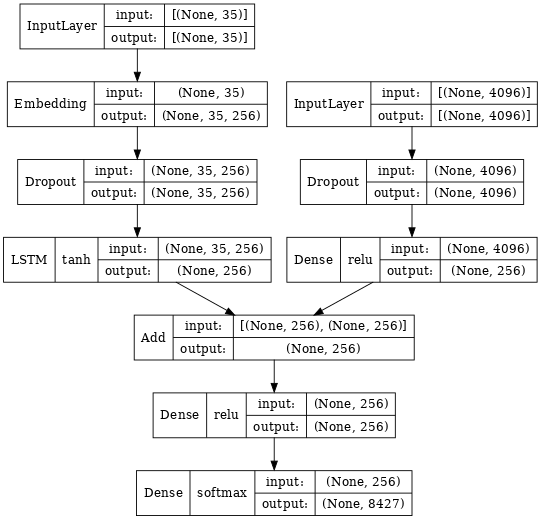

In [26]:
%%time
# encoder model:

# image feature layers
input1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(input1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
input2 =Input(shape=(max_len,))
se1 = Embedding(vocab_size,256,mask_zero=True)(input2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)


# decoder model
decoder1 = add([fe2,se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input1,input2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# show summary
print(model.summary())

# plot the model
os.chdir(WORKING_DIR)
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False, show_layer_activations=True, dpi=64)

In [27]:
%%time
# Training the model:
epochs = 15
batch_size = 64
steps = len(train)//batch_size

es = keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=4)
for i in range(epochs):
    data = dataGenerator(train,captions,features,tok,max_len,vocab_size,batch_size)
    model.fit(data, epochs=1, steps_per_epoch=steps,verbose=1,callbacks=[es])

113/113 [==============================] - 51s 451ms/step - loss: 2.4565
CPU times: user 11min 6s, sys: 4min 57s, total: 16min 3s
Wall time: 16min 42s


In [28]:
model.save('model1.h5')

## Generating Captions

In [29]:
def predict_captions(model,image_feature,tokenizer,max_len):
    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq'
    for i in range(max_len):
        seq = tok.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],maxlen=max_len)
        yhat = model.predict([image_feature,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat,tokenizer)
        if word is None:
            break;
        in_text+=" "+word;
        if word=='enseq':
            break;
    return in_text

In [30]:
%%time
# validate with test data:
actual, predicted = list(), list()

for key in tqdm(test[:20]):
    text = captions[key]
    actual_captions = [caption.split() for caption in text]
    y_pred = predict_captions(model,features[key],tok,max_len)
    predicted_captions = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(predicted_captions)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 15.3 s, sys: 711 ms, total: 16 s
Wall time: 15.6 s


In [31]:
# calculate BLEU score:
from nltk.translate.bleu_score import corpus_bleu
print(f"BLEU-1: {corpus_bleu(actual,predicted,weights=(1.0,0,0,0))}")
print(f"BLEU-2: {corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0))}")

BLEU-1: 0.5217391304347826
BLEU-2: 0.29064075710306186


**Awesome BLEU Score!**

## Generating Captions for dataset Images

In [32]:
def get_captions(path):
    from PIL import Image
    img_id = path.split('/')[-1]
    img_id = img_id.split('.')[0]
    print(img_id)
    image = Image.open(path)
    data = captions[img_id]
    print('------------------Actual------------------')
    for caption in data:
        print(caption)
    y_pred = predict_captions(model,features[img_id],tok,max_len)
    print('------------------Predicted------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')

1016887272_03199f49c4
------------------Actual------------------
stseq collage of one person climbing cliff enseq
stseq group of people are rock climbing on rock climbing wall enseq
stseq group of people climbing rock while one man belays enseq
stseq seven climbers are ascending rock face whilst another man stands holding the rope enseq
stseq several climbers in row are climbing the rock while the man in red watches and holds the line enseq
------------------Predicted------------------
stseq collage of rock climbers climb rock enseq


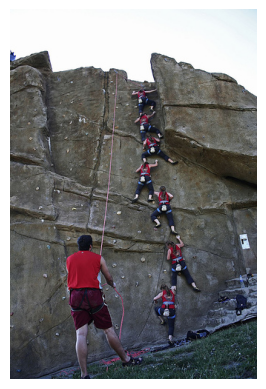

In [33]:
get_captions('/kaggle/input/flickr8k/Images/1016887272_03199f49c4.jpg')

1007320043_627395c3d8
------------------Actual------------------
stseq child playing on rope net enseq
stseq little girl climbing on red roping enseq
stseq little girl in pink climbs rope bridge at the park enseq
stseq small child grips onto the red ropes at the playground enseq
stseq the small child climbs on red ropes on playground enseq
------------------Predicted------------------
stseq child grips from ropes enseq


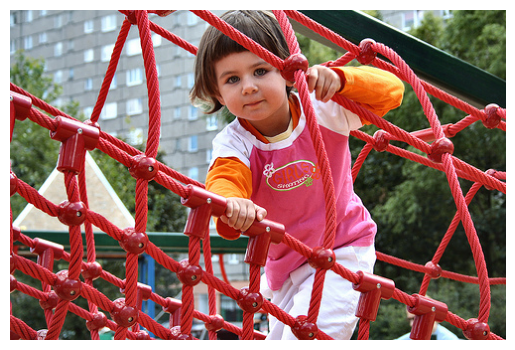

In [34]:
get_captions('/kaggle/input/flickr8k/Images/1007320043_627395c3d8.jpg')

**Good results!**

## Generating captions from Random images

In [35]:
def generate_captions_from_URL(path,CNN,main_model,tokenizer,max_len):
    img_path = path
    image_url = tf.keras.utils.get_file(origin=path )
    img = load_img(image_url, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    feature = CNN.predict(img, verbose=0)
    
    def int_to_word(integer,tokenizer):
        for word,val in tokenizer.word_index.items():
            if val==integer:
                return word
        return None
    in_text = 'stseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq],maxlen=max_len)
        yhat = model.predict([feature,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = int_to_word(yhat,tokenizer)
        if word is None:
            break;
        in_text+=" "+word;
        if word=='enseq':
            break;
    from urllib.request import urlopen
    from PIL import Image
    plt.imshow(Image.open(urlopen(path)))
    plt.title(in_text)
    plt.axis('off')
    plt.show()

10839/10839 [==============================] - 0s 0us/step


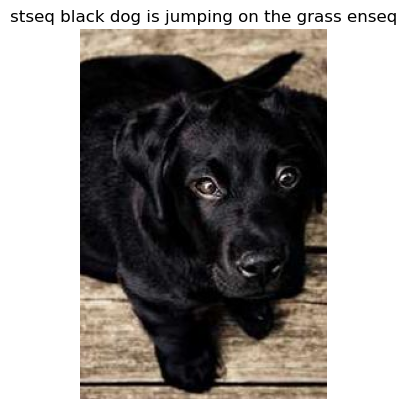

In [36]:
generate_captions_from_URL(path='https://picsum.photos/id/237/200/300',
                  CNN=img_model,main_model=model,tokenizer=tok,max_len=40)

2126411/2126411 [==============================] - 0s 0us/step


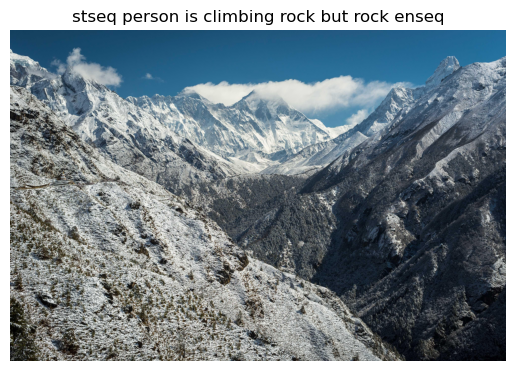

In [37]:
generate_captions_from_URL(path='https://fastly.picsum.photos/id/29/4000/2670.jpg?hmac=rCbRAl24FzrSzwlR5tL-Aqzyu5tX_PA95VJtnUXegGU',
                  CNN=img_model,main_model=model,tokenizer=tok,max_len=40)